In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0, 1" for multiple

# Load the data

In [1]:
! ls

1_Download_and_Preprocess.ipynb
2_Build_Model.ipynb
Demo.ipynb
IssueLabeler.epoch01-val0.84455.hdf5
IssueLabeler.epoch01-val0.86108.hdf5
IssueLabeler.epoch02-val0.84564.hdf5
IssueLabeler.epoch03-val0.83802.hdf5
IssueLabeler.log
IssueLabeler_nbow_.epoch01-val0.89053.hdf5
IssueLabeler_nbow_.epoch01-val0.89168.hdf5
IssueLabeler_nbow_.epoch02-val0.87182.hdf5
IssueLabeler_nbow_.epoch02-val0.88291.hdf5
IssueLabeler_nbow_.epoch03-val0.87658.hdf5
IssueLabeler_nbow_.epoch04-val0.87004.hdf5
IssueLabeler_nbow_.epoch05-val0.86841.hdf5
IssueLabeler_nbow_.log
IssueLabeler_nobd.epoch01-val0.85034.hdf5
IssueLabeler_nobd.epoch02-val0.83598.hdf5
IssueLabeler_nobd.epoch03-val0.83539.hdf5
IssueLabeler_nobd.log
IssueLabeler_nobd_v2.epoch01-val0.48195.hdf5
IssueLabeler_nobd_v2.epoch02-val0.46649.hdf5
IssueLabeler_nobd_v2.log
IssueLabeler_nobd_v3.epoch01-val0.48515.hdf5
IssueLabeler_nobd_v3.epoch02-val0.47624.hdf5
IssueLabeler_nobd_v3.epoch03-val0.47322.hdf5
IssueLabeler_nobd_v3.epoch04-val0.47142.hdf5
Issue

In [2]:
import numpy as np
import dill as dpickle

def load_pickle(fname):
    "load file pickled with dill."
    with open(fname, 'rb') as f:
        pp = dpickle.load(f)
    return pp

In [3]:
#load the text pre-processors
title_pp = load_pickle('title_pp.dpkl')
body_pp = load_pickle('body_pp.dpkl')

#load the training data and labels
train_body_vecs = np.load('train_body_vecs.npy')
train_title_vecs = np.load('train_title_vecs.npy')
train_labels = np.load('train_labels.npy')

#load the test data and labels
test_body_vecs = np.load('test_body_vecs.npy')
test_title_vecs = np.load('test_title_vecs.npy')
test_labels = np.load('test_labels.npy')

Using TensorFlow backend.


In [4]:
# decided to get rid of the last class "other"
train_mask = train_labels != 3
test_mask = test_labels != 3

train_body_vecs = train_body_vecs[train_mask]
train_title_vecs = train_title_vecs[train_mask]
train_labels = train_labels[train_mask]

test_body_vecs = test_body_vecs[test_mask]
test_title_vecs = test_title_vecs[test_mask]
test_labels = test_labels[test_mask]

### Build Model Architecture

In [5]:
import tensorflow as tf
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Embedding, Conv1D, Bidirectional, BatchNormalization, Dot, Flatten, Concatenate
from tensorflow.keras.optimizers import Nadam

In [6]:
tf.__version__

'1.12.0'

In [7]:
issue_body_doc_length = train_body_vecs.shape[1]
issue_title_doc_length = train_title_vecs.shape[1]

body_vocab_size = body_pp.n_tokens
title_vocab_size = title_pp.n_tokens

body_emb_size = 400
title_emb_size = 300

num_classes = len(set(train_labels))

In [7]:
body_input = Input(shape=(issue_body_doc_length,), name='Body-Input')
title_input = Input(shape=(issue_title_doc_length,), name='Title-Input')

b_i = Embedding(body_vocab_size, body_emb_size, name='Body-Embedding', mask_zero=False)(body_input)
b_t = Embedding(title_vocab_size, title_emb_size, name='Title-Embedding', mask_zero=False)(title_input)

b_i = BatchNormalization()(b_i)
b_i = Bidirectional(GRU(300, name='Body-Encoder'))(b_i)

b_t = BatchNormalization()(b_t)
b_t = GRU(300, name='Title-Encoder')(b_t)

b = Concatenate(name='Concat')([b_i, b_t])
#b = Dense(100, activation='relu', name='Dense1')(b_concat)
b = BatchNormalization()(b)
out = Dense(num_classes, activation='softmax')(b)

model = Model([body_input, title_input], out)
parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(optimizer=Nadam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Body-Input (InputLayer)         (None, 140)          0                                            
__________________________________________________________________________________________________
Title-Input (InputLayer)        (None, 10)           0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 140)          0           Body-Input[0][0]                 
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 10)           0           Title-Input[0][0]                
__________________________________________________________________________________________________
lambda_2 (

## Train Model

In [9]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

script_name_base = 'IssueLabeler'
csv_logger = CSVLogger('{:}.log'.format(script_name_base))
model_checkpoint = ModelCheckpoint('{:}.epoch{{epoch:02d}}-val{{val_loss:.5f}}.hdf5'.format(script_name_base),
                                   save_best_only=True)

batch_size = 6400
epochs = 10
history = parallel_model.fit(x=[train_body_vecs, train_title_vecs], 
                             y=np.expand_dims(train_labels, -1),
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.10, 
                             callbacks=[csv_logger, model_checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4486247 samples, validate on 498472 samples
Epoch 1/10
4486247/4486247 [==============================] - 1074s 239us/step - loss: 0.9147 - acc: 0.5811 - val_loss: 0.8611 - val_acc: 0.6023
Epoch 2/10
4486247/4486247 [==============================] - 1061s 236us/step - loss: 0.8317 - acc: 0.6207 - val_loss: 0.8456 - val_acc: 0.6100
Epoch 3/10
4486247/4486247 [==============================] - 1062s 237us/step - loss: 0.7987 - acc: 0.6398 - val_loss: 0.8380 - val_acc: 0.6172
Epoch 4/10
4486247/4486247 [==============================] - 1062s 237us/step - loss: 0.7657 - acc: 0.6587 - val_loss: 0.8441 - val_acc: 0.6164
Epoch 5/10
4486247/4486247 [==============================] - 1061s 237us/step - loss: 0.7277 - acc: 0.6800 - val_loss: 0.8636 - val_acc: 0.6109
Epoch 6/10
4486247/4486247 [==============================] - 1060s 236us/step - loss: 0.6841 - acc: 0.7037 - val_loss: 0.8896 - val_acc: 0.6062
Epoch 7/10
4486247/4486247 [==============================] - 1060s 236us/ste

### Try another approach: Nueral BoW

In [9]:
body_input2 = Input(shape=(issue_body_doc_length,), name='Body-Input')
title_input2 = Input(shape=(issue_title_doc_length,), name='Title-Input')

b_i2 = Embedding(body_vocab_size, body_emb_size//2, name='Body-Embedding', mask_zero=False)(body_input2)
b_t2 = Embedding(title_vocab_size, title_emb_size//2, name='Title-Embedding', mask_zero=False)(title_input2)

token_weights_i = Dense(units=1, activation='sigmoid', use_bias=False)(b_i2)
token_weights_t = Dense(units=1, activation='sigmoid', use_bias=False)(b_t2)

i_emb = Dot(axes=1, normalize=True, name='body_encoding')([b_i2, token_weights_i])
i = Flatten()(i_emb)
t_emb = Dot(axes=1, normalize=True, name='title_encoding')([b_t2, token_weights_t])
t = Flatten()(t_emb)

b = Concatenate(name='Concat')([i, t])
b = Dense(100, activation='relu', name='Dense1')(b)
b = BatchNormalization()(b)
out = Dense(num_classes, activation='softmax')(b)

model2 = Model([body_input2, title_input2], out)
parallel_model_nbow = multi_gpu_model(model2, gpus=4)
parallel_model_nbow.compile(optimizer=Nadam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Body-Input (InputLayer)         (None, 140)          0                                            
__________________________________________________________________________________________________
Title-Input (InputLayer)        (None, 10)           0                                            
__________________________________________________________________________________________________
Body-Embedding (Embedding)      (None, 140, 200)     1600200     Body-Input[0][0]                 
__________________________________________________________________________________________________
Title-Embedding (Embedding)     (None, 10, 150)      750150      Title-Input[0][0]                
__________________________________________________________________________________________________
dense_3 (D

In [11]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

script_name_base = 'IssueLabeler_nbow_'
csv_logger = CSVLogger('{:}.log'.format(script_name_base))
model_checkpoint = ModelCheckpoint('{:}.epoch{{epoch:02d}}-val{{val_loss:.5f}}.hdf5'.format(script_name_base),
                                   save_best_only=True)

batch_size = 20000
epochs = 10
history = parallel_model_nbow.fit(x=[train_body_vecs, train_title_vecs], 
                             y=np.expand_dims(train_labels, -1),
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.10, 
                             callbacks=[csv_logger, model_checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4486247 samples, validate on 498472 samples
Epoch 1/10
4486247/4486247 [==============================] - 51s 11us/step - loss: 0.9772 - acc: 0.5655 - val_loss: 0.8917 - val_acc: 0.5899
Epoch 2/10
4486247/4486247 [==============================] - 48s 11us/step - loss: 0.8704 - acc: 0.6014 - val_loss: 0.8829 - val_acc: 0.5938
Epoch 3/10
4486247/4486247 [==============================] - 47s 11us/step - loss: 0.8521 - acc: 0.6115 - val_loss: 0.8766 - val_acc: 0.5951
Epoch 4/10
4486247/4486247 [==============================] - 48s 11us/step - loss: 0.8530 - acc: 0.6122 - val_loss: 0.8700 - val_acc: 0.6013
Epoch 5/10
4486247/4486247 [==============================] - 48s 11us/step - loss: 0.8273 - acc: 0.6262 - val_loss: 0.8684 - val_acc: 0.6026
Epoch 6/10
4486247/4486247 [==============================] - 47s 11us/step - loss: 0.8100 - acc: 0.6365 - val_loss: 0.8790 - val_acc: 0.5985
Epoch 7/10
4486247/4486247 [==============================] - 47s 10us/step - loss: 0.7941 - ac

## Without Bi-Directional

In [19]:
body_emb_size

400

In [26]:
body_input = Input(shape=(issue_body_doc_length,), name='Body-Input')
title_input = Input(shape=(issue_title_doc_length,), name='Title-Input')

b_i = Embedding(body_vocab_size, 100, name='Body-Embedding', mask_zero=False)(body_input)
b_t = Embedding(title_vocab_size, 100, name='Title-Embedding', mask_zero=False)(title_input)

b_i = BatchNormalization()(b_i)
b_i = GRU(200, name='Body-Encoder')(b_i)

b_t = BatchNormalization()(b_t)
b_t = GRU(150, name='Title-Encoder')(b_t)

b = Concatenate(name='Concat')([b_i, b_t])
#b = Dense(100, activation='relu', name='Dense1')(b_concat)
b = BatchNormalization()(b)
out = Dense(num_classes, activation='softmax')(b)

model = Model([body_input, title_input], out)
parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(optimizer=Nadam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Body-Input (InputLayer)         (None, 140)          0                                            
__________________________________________________________________________________________________
Title-Input (InputLayer)        (None, 10)           0                                            
__________________________________________________________________________________________________
Body-Embedding (Embedding)      (None, 140, 100)     800100      Body-Input[0][0]                 
__________________________________________________________________________________________________
Title-Embedding (Embedding)     (None, 10, 100)      500100      Title-Input[0][0]                
__________________________________________________________________________________________________
batch_norm

In [28]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

script_name_base = 'IssueLabeler_nobd_v3'
csv_logger = CSVLogger('{:}.log'.format(script_name_base))
model_checkpoint = ModelCheckpoint('{:}.epoch{{epoch:02d}}-val{{val_loss:.5f}}.hdf5'.format(script_name_base),
                                   save_best_only=True)

batch_size = 10000
epochs = 10
history = parallel_model.fit(x=[train_body_vecs, train_title_vecs], 
                             y=np.expand_dims(train_labels, -1),
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.10, 
                             callbacks=[csv_logger, model_checkpoint])

Train on 2429154 samples, validate on 269907 samples
Epoch 1/10
2429154/2429154 [==============================] - 194s 80us/step - loss: 0.5573 - acc: 0.7867 - val_loss: 0.4852 - val_acc: 0.8162
Epoch 2/10
2429154/2429154 [==============================] - 181s 75us/step - loss: 0.4665 - acc: 0.8226 - val_loss: 0.4762 - val_acc: 0.8182
Epoch 3/10
2429154/2429154 [==============================] - 181s 75us/step - loss: 0.4456 - acc: 0.8302 - val_loss: 0.4732 - val_acc: 0.8197
Epoch 4/10
2429154/2429154 [==============================] - 181s 75us/step - loss: 0.4285 - acc: 0.8367 - val_loss: 0.4714 - val_acc: 0.8227
Epoch 5/10
2429154/2429154 [==============================] - 180s 74us/step - loss: 0.4114 - acc: 0.8434 - val_loss: 0.4722 - val_acc: 0.8218
Epoch 6/10
2429154/2429154 [==============================] - 181s 74us/step - loss: 0.3932 - acc: 0.8507 - val_loss: 0.4832 - val_acc: 0.8179
Epoch 7/10
2429154/2429154 [==============================] - 181s 75us/step - loss: 0.37

In [8]:
from tensorflow.keras.models import load_model
model = load_model('IssueLabeler_nobd_v3.epoch04-val0.47142.hdf5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# Share Vocabularies

I noticed model is still overparameterized and the place where the most parameters are in the embeddings, which makes me want to try sharing the embeddings.

In [5]:
import pandas as pd

traindf = pd.read_pickle('traindf.pkl')
testdf = pd.read_pickle('testdf.pkl')
body_pp = load_pickle('body_pp.dpkl')

train_title_vecs = body_pp.transform_parallel(traindf[~traindf.c_other].title.tolist())
test_title_vecs = body_pp.transform_parallel(testdf[~testdf.c_other].title.tolist())

In [6]:
#load the training data and labels
train_body_vecs = np.load('train_body_vecs.npy')
train_labels = np.load('train_labels.npy')

#load the test data and labels
test_body_vecs = np.load('test_body_vecs.npy')
test_labels = np.load('test_labels.npy')


# decided to get rid of the last class "other"
train_mask = train_labels != 3
test_mask = test_labels != 3

train_body_vecs = train_body_vecs[train_mask]
train_labels = train_labels[train_mask]

test_body_vecs = test_body_vecs[test_mask]
test_labels = test_labels[test_mask]

In [8]:
issue_body_doc_length = train_body_vecs.shape[1]
issue_title_doc_length = train_title_vecs.shape[1]

body_vocab_size = body_pp.n_tokens

num_classes = len(set(train_labels))

In [7]:
import tensorflow as tf
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Embedding, Conv1D, Bidirectional, BatchNormalization, Dot, Flatten, Concatenate
from tensorflow.keras.optimizers import Nadam

In [9]:
body_input = Input(shape=(issue_body_doc_length,), name='Body-Input')
title_input = Input(shape=(issue_title_doc_length,), name='Title-Input')

emb = Embedding(body_vocab_size, 100, name='Shared-Embedding', mask_zero=False)

#share embedding weights
b_i = emb(body_input)
b_t = emb(title_input)

b_i = BatchNormalization()(b_i)
b_i = GRU(200, name='Body-Encoder')(b_i)

b_t = BatchNormalization()(b_t)
b_t = GRU(150, name='Title-Encoder')(b_t)

b = Concatenate(name='Concat')([b_i, b_t])
#b = Dense(100, activation='relu', name='Dense1')(b_concat)
b = BatchNormalization()(b)
out = Dense(num_classes, activation='softmax')(b)

model = Model([body_input, title_input], out)
# 

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Body-Input (InputLayer)         (None, 140)          0                                            
__________________________________________________________________________________________________
Title-Input (InputLayer)        (None, 140)          0                                            
__________________________________________________________________________________________________
Shared-Embedding (Embedding)    (None, 140, 100)     800100      Body-Input[0][0]                 
                                                                 Title-Input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 140, 100)     400         Shared-Embedding[0][0]           
__________

In [11]:
parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(optimizer=Nadam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

script_name_base = 'IssueLabeler_sharedemb_v1'
csv_logger = CSVLogger('{:}.log'.format(script_name_base))
model_checkpoint = ModelCheckpoint('{:}.epoch{{epoch:02d}}-val{{val_loss:.5f}}.hdf5'.format(script_name_base),
                                   save_best_only=True)

batch_size = 15000
epochs = 10
history = parallel_model.fit(x=[train_body_vecs, train_title_vecs], 
                             y=np.expand_dims(train_labels, -1),
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.10, 
                             callbacks=[csv_logger, model_checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2429154 samples, validate on 269907 samples
Epoch 1/10
 975000/2429154 [===========>..................] - ETA: 2:58 - loss: 0.7028 - acc: 0.7280

# Confusion Matrix

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [10]:
preds = model.predict(x=[test_body_vecs, test_title_vecs], batch_size=1000)

In [11]:
y_pred = np.argmax(preds, axis=1)

In [12]:
y_test = test_labels

In [13]:
class_names = np.array(['bug', 'feature', 'question'])

Normalized confusion matrix
[[0.85 0.14 0.02]
 [0.1  0.88 0.02]
 [0.26 0.3  0.44]]


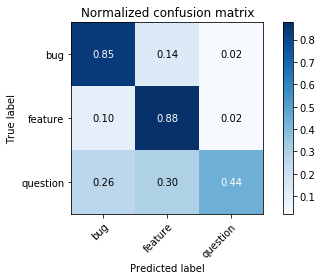

In [14]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [15]:
mistakes = y_pred != y_test

In [25]:
import pandas as pd
pd.set_option('max_colwidth', 1000)
df = pd.read_pickle('testdf.pkl')
df = df[~ df.c_other]
df['prediction'] = [class_names[i] for i in y_pred]

In [26]:
mistakes_df = df[mistakes]

In [27]:
mistakes_df

,url,repo,title,body,num_labels,labels,num_concurrent_classes,c_bug,c_feature,c_question,c_other,prediction
327903,"""https://github.com/magento/data-migration-tool/issues/529""",magento/data-migration-tool,after migration+checkout page blank only logo is showing,"i've migrated from m1.9.3.4 to m2.1.8 but when i goto checkout page after adding product to cart it's shows empty page, only logo is showing.\r \r while other pages are fine.\r \r screenshots :- \r \r ! checkout-page-empty https://user-images.githubusercontent.com/13333191/40978738-9ecee77a-68f1-11e8-82fe-23314e1b9648.png \r \r thanks!!!\r \r \r",1,"[""question""]",1,False,False,True,False,bug
427704,"""https://github.com/Itseez/opencv/issues/6076""",Itseez/opencv,undefined references after building on ubuntu,"i had opencv version 2.4.12 running fine on my computer. i then built and installed version 3.1.0. now when i compile, i get\r \r /tmp/ccjxy4xg.o: in function cvpointfrom32f':\r /usr/local/include/opencv2/core/types_c.h:929: undefined reference to cvround'\r /usr/local/include/opencv2/core/types_c.h:930: undefined reference to cvround'\r /tmp/ccjxy4xg.o: in function cvreadint':\r /usr/local/include/opencv2/core/core_c.h:2318: undefined reference to cvround'\r /tmp/ccjxy4xg.o: in function cvellipsebox':\r /usr/local/include/opencv2/imgproc/imgproc_c.h:1041: undefined reference to cvround'\r /usr/local/include/opencv2/imgproc/imgproc_c.h:1042: undefined reference to cvround'\r collect2: error: ld returned 1 exit status\r \r \r i am compiling the following code.c file:\r \r include \ opencv2/highgui/highgui_c.h\ \r include <stdio.h>\r int main int argc, char argv \r {\r return 0;\r }\r \r i am compiling it using \r \r gcc -ggdb pkg-config opencv --cf...",2,"[""category: build/install"", ""question""]",1,False,False,True,False,bug
115036,"""https://github.com/Andyjd86/ins-database/issues/15""",Andyjd86/ins-database,network path creation,"the following is the proposed method for creating, storing and making ordered continuous paths available to the lrs database.\r \r 1. run the \ walk_network\ function to produce a tree root to leaves type structure. \r \r for now, focus on the main carriageway.\r \r 2. find all the leaves endpoints of all branches . \r unnest these paths into their individual sections in a new table, along with a newly assigned \ path number\ .\r \r insert into client.path_master\r \t fid_trail, fid_last \r \t select fid_trail, gid \r \tfrom client.network_walk \r \twhere gid \r \tnot in\r \t\t select unnest fid_trail 0:array_length fid_trail,1 -1 \r \t\tfrom client.network_walk\r \t\t \r \t ;\r \r ! image https://user-images.githubusercontent.com/24847630/35582100-aa3450ba-05e5-11e8-84b0-5a485d1c4a78.png \r \r 3. show these paths in qgis, this informs the user what has been done automatically. \r \r <img src=\ https://user-images.githubusercontent.com/24847630/35584915-5b...",4,"[""help wanted"", ""idea"", ""implementation"", ""question""]",1,False,False,True,False,feature
434724,"""https://github.com/zulip/zulip/issues/9396""",zulip/zulip,typeahead: \ keydown\ events for enter and arrow keys should be ignored while \ composition\,"first, i describe what is the \ composition\ .\r \r in cjk language regions, people use some software named \ im\ input method to input heir local language text. for example, when i search a japanese term \ 日本語\ means \ japanese language\ in a zulip instance with firefox, i need to do:\r \r 1. click the search field.\r 2. activate the im. the \ composition\ session starts.\r 3. type keys: n , i , h , o , and n . in a composition session \r 4. hit the space key to convert the text to japanese term. \ 日本\ is suggested. in a composition session \r 5. hit the enter key to determine the text \ 日本\ . in a composition session \r 6. type keys: g , and o . in a composition session \r 7. hit the space key to convert the text to japanese term. \ 語\ is suggested. in a composition session \r 8. hit the enter key to determine the tex

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt

(array([  586.,  2331.,  8821., 10839., 11815., 13705., 17155., 23454.,
        38482., 86098.]),
 array([0.34, 0.4 , 0.47, 0.54, 0.6 , 0.67, 0.74, 0.8 , 0.87, 0.93, 1.  ],
       dtype=float32),
 <a list of 10 Patch objects>)

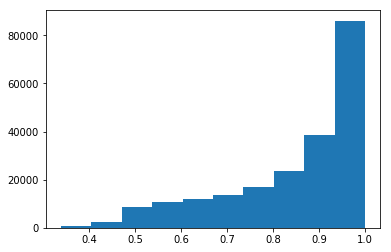

In [29]:
plt.hist(preds[:, 0][y_pred == 0])

# Try DR

In [31]:
testdf = pd.read_pickle('testdf.pkl')
testdf['partition'] = 'test'

traindf = pd.read_pickle('traindf.pkl')
traindf['partition'] = 'train'

In [36]:
original_data = pd.concat([traindf, testdf])
original_data = original_data[~original_data.c_other]

In [39]:
def collapse_label(x):
    if x.c_bug:
        return 'bug'
    elif x.c_feature:
        return 'feature'
    
    return 'question'

In [41]:
original_data['class_label'] = original_data.apply(lambda x: collapse_label(x), axis=1)

In [42]:
original_data.head()

,url,repo,title,body,num_labels,labels,num_concurrent_classes,c_bug,c_feature,c_question,c_other,partition,class_label
68065,"""https://github.com/ESMCI/cime/issues/2435""",ESMCI/cime,can we stop copying log files to the case directory?,"i was talking to @cecilehannay about disk space issues on cheyenne. she pointed out that it's often useful to keep case directories around for a long time, but they take up much more space than they need to because the log files are copied into your case directory. can we stop copying log files into your case directory, just leaving them in your archive directory?",3,"[""in progress"", ""tp: CIMElib"", ""ty: enhancement""]",1,False,True,False,False,train,feature
75697,"""https://github.com/prescottprue/react-redux-firebase/issues/51""",prescottprue/react-redux-firebase,isloaded helper always returns false when a default value is supplied to datatojs,"if you provide a default value to datatojs the isloaded helper always returns true, meaning loading spinners cannot be displayed.\r \r minimal working example from the yo generator: https://github.com/will-hart/react-redux-firebase-mwe\r \r all the action is in here https://github.com/will-hart/react-redux-firebase-mwe/tree/master/src/routes/home\r \r database looks like this:\r \r ! image https://cloud.githubusercontent.com/assets/391950/22526729/79c71ca6-e920-11e6-88a8-71999bee4d33.png \r",1,"[""enhancement""]",1,False,True,False,False,train,feature
256798,"""https://github.com/PX4/Firmware/issues/8148""",PX4/Firmware,reboot via qgc does not restore dropped rc connection,"quite often i have the rc control stop working after powering on the autopilot. it doesn't lose signal or indicate lost connection in qgc, it just stops responding to inputs from the rc radio. this only happens before arming, never after. it seems to not happen if i constantly move the sticks pretty regularly, but if left alone for a minute.\r \r i'm not sure why this happens, but at the least if i could reboot via qgc and restore control that would be fine. that doesn't work however, so i have to open a hatch and physically unplug the power. is there a known reason why the autopilot stops responding to input? if it's a big process to fix the issue, is there a way to restore it via software reboot for the short term?\r",2,"[""bug"", ""status/STALE""]",1,True,False,False,False,train,bug
189228,"""https://github.com/Tizra/Tizra-Customer-Tracker/issues/460""",Tizra/Tizra-Customer-Tracker,unpublish doesn't work from lists,"when i try to unpublish items by checking them off on a list then clicking unpublish nothing happens. delete and publish operations seem to be ok.\r \r tested on collections, documents, excerpts and static pages.\r \r",2,"[""bug"", ""duplicate""]",1,True,False,False,False,train,bug
1108,"""https://github.com/agda/agda/issues/2431""",agda/agda,making the uhc backend a stand-alone product,"i've put together an api for compiler backends for some students of mine. this makes it easy to write backends using agda as a library. basically you implement a few callbacks in a backend type and then define\r \r haskell\r main = runagda mybackend \r \r \r this gets you a fully functional agda executable with your backend included.\r \r i've successfully migrated the ghc and uhc backends to use this api. now, i would like to exploit this to separate the uhc backend from the agda code base. as far as i see things, there is a strong case for doing this:\r \r - uhc is an research compiler which not heavily maintained.\r - as far as i know, no one is relying on the uhc backend.\r - the uhc backend is costing us a non-trivial bit of maintenance work.\r - a separate uhc backend can still be maintained in its own repo, but it would only need to be updated for every new release, instead of every time something changes that affects the backends.\r \r anyway, i thought i'd check i...",3,"[""discussion"", ""task"", ""uhc-backend"", ""discussion"", ""task"", ""uhc-backend""]",1,False,False

In [44]:
original_data[['repo', 'title', 'body', 'class_label', 'partition']].to_csv('issue_label_forDR.csv', index=False)

In [46]:
original_data.groupby('partition').count()

,url,repo,title,body,num_labels,labels,num_concurrent_classes,c_bug,c_feature,c_question,c_other,class_label
partition,,,,,,,,,,,,
test,476064,476064,476064,476064,476064,476064,476064,476064,476064,476064,476064,476064
train,2699061,2699061,2699061,2699061,2699061,2699061,2699061,2699061,2699061,2699061,2699061,2699061
